<a href="https://colab.research.google.com/github/eliottpark/VS265/blob/main/spiking_neurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Spiking Neurons#
### Introducing stochasticity to TPAM (Threshold Phasor Associative Memory) ###
This work and notebook is heavily based on the work done by E. Paxon Frady and Friedrich T. Sommer in [Robust computation with rhythmic spike patterns](https://doi.org/10.1073/pnas.1902653116). 

This work implements a novel thresholding function on top of Paxon and Sommer's TPAM network that aims at increasing robustness to noise. This function fits a Von Mises distribution over the activations of a single layer and samples the activation threshold used at that layer from this distribution. We found that we were able to get increased robustness to noise at the cost of lower precision and recall. For a more in depth discussion, visit [this site](https://www.notion.so/Stochastic-Threshold-Phasor-Associative-Memories-303da0b4267f49f0ad355963f247d51a).

------------------------------

Eliott Park and Jwalin Joshi

VisSci 265, Fall 2020

UC Berkeley 

In [ ]:
!pip install brian2

     |████████████████████████████████| 1.2MB 7.6MB/s 
     |████████████████████████████████| 5.9MB 16.1MB/s 
  Created wheel for brian2: filename=Brian2-2.4.2-cp36-cp36m-linux_x86_64.whl size=1257531 sha256=6753fd437364fee7d9fac460e7a72599e10ff89ad96dc91fa088080af597a0ec
  Stored in directory: /root/.cache/pip/wheels/5d/4b/cf/ef50e71df5479d67f981cbb17b1d842381019d27ba144d57de
Successfully built brian2
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [ ]:
from __future__ import division

from pylab import *
from brian2 import *
import time

from brian2.units.allunits import henry
from scipy.stats import vonmises
from scipy.stats import norm as s_norm
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'text.usetex': False})
# matplotlib.rcParams['text.latex.preamble'] = [
#     r'\usepackage{amsmath}',
#     r'\usepackage{amssymb}']
plt.rcParams.update({'font.family': 'serif', 
                     'font.serif':['Computer Modern']})

In [ ]:
def crvec(N, D=1):
    rphase = 2*np.pi * np.random.rand(D, N)
    return np.cos(rphase) + 1.0j * np.sin(rphase)

In [ ]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

In [ ]:
def activation_thresh(x, sigma=0.0, c_thresh=None):
    
    if c_thresh is None:
        N = x.shape[0]
        c_thresh = 2.0 / N**0.5
        
    xn = np.abs(x)
    
    a = (x ) / (np.abs(x) + 1e-12)
    a[xn < c_thresh] = 0
    
    return a

In [ ]:
def cviz_im(cvec):
    ss = int(len(cvec)**0.5)
    
    ss_idx = ss**2
    
    im_cvec = np.zeros((ss, ss,3))
#     im_cvec[:,:,3]=1
    c=0
    for i in range(ss):
        for j in range(ss):
            if np.abs(cvec[c]) > 0.05:
                im_cvec[i,j,:] = matplotlib.colors.hsv_to_rgb([(np.angle(cvec[c])/2/pi + 1) % 1, 1, 1])
                
            c+=1
                
    return im_cvec

In [ ]:
def phase2spikes(cv, freq=5.0):
    st = np.angle(cv) / (2*pi*freq)
    return st


In [ ]:
def my_cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [ ]:
def phasor_similarity(vec1, vec2):
  difference = np.abs(vec1 - vec2)
  return np.abs(np.exp(1j*difference).sum())/len(vec1)

In [ ]:
def angle_similarity(vec1, vec2):
  diff = np.angle(vec1) - np.angle(vec2)
  return np.cos(diff).sum()/len(diff)

In [ ]:
def hot_angle_similarity(input, target):
  # Get indices where val in target != 0
  indices = np.nonzero(target)
  diff = np.angle(target[indices]) - np.angle(input[indices])
  return np.cos(diff).sum()/len(diff)

# TPAM #

## Store random sparse phasor patterns in network ##

In [ ]:
N=25**2
D=201
Ks=25

letter_vectors_c = crvec(N, D)

for d in range(D):
    ip = np.random.choice(N, size=(N-Ks), replace=False)
    letter_vectors_c[d, ip] = 0
    
letter_vectors = 2 * (np.random.randn(D,N) < 0) - 1

In [ ]:
J_c = np.dot(letter_vectors_c.T, np.conj(letter_vectors_c))
np.fill_diagonal(J_c, 0)

## Network dynamics and simulations ##

WARNING    /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]
WARNING    /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 [py.warnings]
WARNING    /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]
WARNING    /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 [py.warnings]
WARNING    /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]
WARNING    /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 [py.warnings]
WARNING    /usr/local/lib/py

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


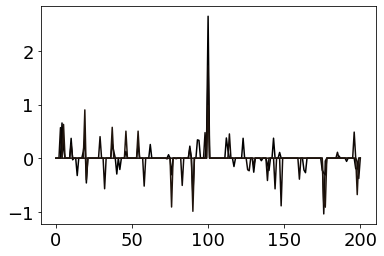

In [ ]:
max_steps = 20
hop_hist = np.zeros((D, max_steps+1))
hop_s_hist = np.zeros((N, max_steps+1), 'complex')

target_idx = 100

hop_state_i = letter_vectors_c[target_idx,:].copy()
hop_state_i[:300] = 0

noise_state = 0.0 * np.random.randn(N) * np.squeeze(crvec(N,1)) #2*(np.random.randn(N) < 0) - 1
hop_state = hop_state_i + noise_state

hop_state /= norm(hop_state)

cols = get_cmap('copper', max_steps)

c_thresh = 0.6/Ks**0.5
for i in range(max_steps):
    hop_hist[:,i] = np.real(np.dot(np.conj(letter_vectors_c), hop_state))    
    hop_s_hist[:,i] = hop_state
    
    hop_u = np.dot(J_c, hop_state) / Ks
    hop_state = activation_thresh(hop_u, c_thresh=c_thresh )
    hop_state /= norm(hop_state)

    plot(hop_hist[:,i], c=cols(i))

hop_hist[:,i+1] =  np.real(np.dot(np.conj(letter_vectors_c), hop_state))
plot(hop_hist[:,i], c=cols(i))

Text(0.5, 1.0, 'Target')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


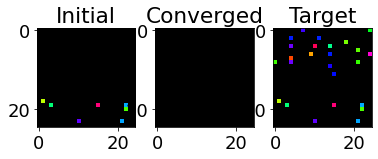

In [ ]:
figure(figsize=(6,3))

subplot(131)
imshow(cviz_im(hop_state_i))
title('Initial')
subplot(132)
imshow(cviz_im(hop_s_hist[:, -2]))
title('Converged')
subplot(133)
imshow(cviz_im(letter_vectors_c[target_idx,:]))
title('Target')

# Stochastic TPAM #

In [ ]:
def stochastic_activation_thresh(x, k, sigma=0.0, type='vonmises'):
  """
  Take a von mises distribution over the incoming data and sample
  a threshold.
  """
  top_k = np.sort(x)[-k:][::-1]
  if type == 'vonmises':
    norm_angle = (np.angle(top_k) + np.pi)/(2*np.pi)
    dist = vonmises.fit(norm_angle, fscale=1)
    c_thresh = vonmises.rvs(kappa=dist[0]*10, loc=0.2*dist[1])
  elif type == 'norm':
    dist = s_norm.fit(np.abs(top_k), fscale=1)
    c_thresh = s_norm.rvs(scale=dist[1], loc=0.2*dist[0])
  else: 
    N = x.shape[0]
    c_thresh = 2.0 / N**0.5
      
  xn = np.abs(x)
  
  a = (x) / (np.abs(x) + 1e-12)
  a[xn < c_thresh] = 0
  
  return a

## Store random sparse phasors in network ##

In [ ]:
N=25**2
D=201
Ks=25

letter_vectors_c = crvec(N, D)

for d in range(D):
    ip = np.random.choice(N, size=(N-Ks), replace=False)
    letter_vectors_c[d, ip] = 0
    
letter_vectors = 2 * (np.random.randn(D,N) < 0) - 1

In [ ]:
J_c = np.dot(letter_vectors_c.T, np.conj(letter_vectors_c))
np.fill_diagonal(J_c, 0)

## Network dynamics and simulations ##

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)


max_steps = 20

hop_hist = np.zeros((D, max_steps+1))
hop_s_hist = np.zeros((N, max_steps+1), 'complex')

target_idx = 100

hop_state_i = letter_vectors_c[target_idx,:].copy()
hop_state_i[:300] = 0

noise_state = 0.2 * np.random.randn(N) * np.squeeze(crvec(N,1)) #2*(np.random.randn(N) < 0) - 1
hop_state = hop_state_i + noise_state

hop_state /= norm(hop_state)

# Stochastic version
hop_hist_stc = np.zeros((D, max_steps+1))
hop_s_hist_stc = np.zeros((N, max_steps+1), 'complex')

target_idx = 100

hop_state_i_stc = letter_vectors_c[target_idx,:].copy()
hop_state_i_stc[:300] = 0

noise_state_stc = 0.2 * np.random.randn(N) * np.squeeze(crvec(N,1)) #2*(np.random.randn(N) < 0) - 1
hop_state_stc = hop_state_i_stc + noise_state_stc

hop_state_stc /= norm(hop_state_stc)

cols = get_cmap('copper', max_steps)

c_thresh = 0.6/Ks**0.5
for i in range(max_steps):
    hop_hist[:,i] = np.real(np.dot(np.conj(letter_vectors_c), hop_state))    
    hop_s_hist[:,i] = hop_state
    
    hop_u = np.dot(J_c, hop_state) / Ks
    # ax2.plot(hop_u[:,i], c=cols(i))
    print("regular threshold: ", c_thresh)
    # print("original: ",hop_u[:50])
    hop_state = activation_thresh(hop_u, c_thresh=c_thresh )
    # print("original: ",hop_state[:50])
    hop_state /= norm(hop_state)

    ax0.plot(hop_hist[:,i], c=cols(i))

    # Stochastic version
    hop_hist_stc[:,i] = np.real(np.dot(np.conj(letter_vectors_c), hop_state_stc))    
    hop_s_hist_stc[:,i] = hop_state_stc

    hop_u_stc = np.dot(J_c, hop_state_stc) / Ks
    # ax3.plot(hop_u_stc[:,i], c=cols(i))
    # print("Stochastic: ", hop_u_stc[:50])
    hop_state_stc = stochastic_activation_thresh(hop_u_stc, k=Ks)
    # print("Stochastic: ", hop_state_stc[:50])

    hop_state_stc /= norm(hop_state_stc)

    ax1.plot(hop_hist_stc[:,i], c=cols(i))

ax0.set_title("Normal thresholding")
hop_hist[:,i+1] =  np.real(np.dot(np.conj(letter_vectors_c), hop_state))
ax0.plot(hop_hist[:,i], c=cols(i))

ax1.set_title("Stochastic thresholding from von mises ")
hop_hist_stc[:,i+1] =  np.real(np.dot(np.conj(letter_vectors_c), hop_state_stc))
ax1.plot(hop_hist_stc[:,i], c=cols(i))

In [ ]:
figure(figsize=(6,6))

subplot(231)
imshow(cviz_im(hop_state_i))
title('Initial')
subplot(232)
imshow(cviz_im(hop_s_hist[:, -2]))
title('Converged')
subplot(233)
imshow(cviz_im(letter_vectors_c[target_idx,:]))
title('Target')

subplot(234)
imshow(cviz_im(hop_state_i_stc))
title('Initial')
subplot(235)
imshow(cviz_im(hop_s_hist_stc[:, -2]))
title('Converged')
subplot(236)
imshow(cviz_im(letter_vectors_c[target_idx,:]))
title('Target')

## Test similarity vs noise ##

In [ ]:
def test_thresholds(noise=0.0, layered=False, show_image=False):
  max_steps = 20

  hop_hist = np.zeros((D, max_steps+1))
  hop_s_hist = np.zeros((N, max_steps+1), 'complex')

  target_idx = 100

  hop_state_i = letter_vectors_c[target_idx,:].copy()

  if layered:
    layer1 = noise * letter_vectors_c[target_idx-1,:].copy()
    # layer1[:100] = 0
    layer2 = noise * letter_vectors_c[target_idx*5%len(letter_vectors_c),:].copy()
    # layer2[100:] = 0
    hop_state_i += layer1 
  else:
    hop_state_i[:400] = 0

  noise_state = noise * np.random.randn(N) * np.squeeze(crvec(N,1)) #2*(np.random.randn(N) < 0) - 1
  
  hop_state = hop_state_i + noise_state

  hop_state /= norm(hop_state)

  noisy_hop_state_i = hop_state

  # Stochastic version
  hop_hist_stc = np.zeros((D, max_steps+1))
  hop_s_hist_stc = np.zeros((N, max_steps+1), 'complex')

  hop_state_stc = hop_state_i + noise_state

  hop_state_stc /= norm(hop_state_stc)

  cols = get_cmap('copper', max_steps)

  c_thresh = 0.6/Ks**0.5
  for i in range(max_steps):
      hop_hist[:,i] = np.real(np.dot(np.conj(letter_vectors_c), hop_state))    
      hop_s_hist[:,i] = hop_state
      
      hop_u = np.dot(J_c, hop_state) / Ks
      hop_state = activation_thresh(hop_u, c_thresh=c_thresh )

      hop_state /= (norm(hop_state) + 1**-10)

      # Stochastic version
      hop_hist_stc[:,i] = np.real(np.dot(np.conj(letter_vectors_c), hop_state_stc))    
      hop_s_hist_stc[:,i] = hop_state_stc

      hop_u_stc = np.dot(J_c, hop_state_stc) / Ks
      hop_state_stc = stochastic_activation_thresh(hop_u_stc, k=Ks)

      hop_state_stc /= (norm(hop_state_stc) + 1**-10)

  orig_output = hop_s_hist[:, -2]
  stc_output = hop_s_hist_stc[:, -2]
  target = letter_vectors_c[target_idx,:]

  orig = angle_similarity(orig_output, target)
  stochastic = angle_similarity(stc_output, target)
  hot_orig = hot_angle_similarity(orig_output, target)
  hot_stochastic = hot_angle_similarity(stc_output, target)

  if show_image:
    figure(figsize=(8,6))

    subplot(241)
    imshow(cviz_im(hop_state_i))
    title('Initial')
    subplot(242)
    imshow(cviz_im(noisy_hop_state_i))
    title('Noisy')
    subplot(243)
    imshow(cviz_im(hop_s_hist[:, -2]))
    title('Converged')
    subplot(244)
    imshow(cviz_im(letter_vectors_c[target_idx,:]))
    title('Target')

    subplot(245)
    imshow(cviz_im(hop_state_i))
    title('Initial')
    subplot(246)
    imshow(cviz_im(noisy_hop_state_i))
    title('Noisy')
    subplot(247)
    imshow(cviz_im(hop_s_hist_stc[:, -2]))
    title('Converged')
    subplot(248)
    imshow(cviz_im(letter_vectors_c[target_idx,:]))
    title('Target')

  return orig, stochastic, hot_orig, hot_stochastic

In [ ]:
N=25**2
D=201
Ks=25

letter_vectors_c = crvec(N, D)

for d in range(D):
    ip = np.random.choice(N, size=(N-Ks), replace=False)
    letter_vectors_c[d, ip] = 0
    
letter_vectors = 2 * (np.random.randn(D,N) < 0) - 1

In [ ]:
J_c = np.dot(letter_vectors_c.T, np.conj(letter_vectors_c))
np.fill_diagonal(J_c, 0)

In [ ]:
noise = 0.25
print("noise: ",noise)
o, s, o_h, s_h = test_thresholds(noise=noise, layered=True, show_image=True)
print(f'original similarity: {o}, stochastic similarity: {s}')
print(f'hot original similarity: {o_h}, stochastic similarity: {s_h}')

In [ ]:
noise = 0.20
print("noise: ",noise)
o, s, o_h, s_h = test_thresholds(noise=noise, show_image=True)
print(f'original similarity: {o}, stochastic similarity: {s}')
print(f'hot original similarity: {o_h}, stochastic similarity: {s_h}')

In [ ]:

num_samples = 10
o_means = []
s_means = []
o_h_means = []
s_h_means = []
o_medians = []
s_medians = []
o_h_medians = []
s_h_medians  = []
o_variance = []
s_variance = []
o_h_variance = []
s_h_variance = []
for _ in range(num_samples):
  o_set = []
  s_set = []
  o_h_set = []
  s_h_set = []
  x = np.linspace(0,0.4,num=100)
  for noise in x:
    print("noise: ",noise)
    o, s, o_h, s_h = test_thresholds(noise=noise)
    # print(f'original similarity: {o}, stochastic similarity: {s}')
    o_set.append(o)
    s_set.append(s)
    o_h_set.append(o_h)
    s_h_set.append(s_h)
    
  o_means.append(np.mean(o_set))
  s_means.append(np.mean(s_set))
  print(f'original mean similarity: {np.mean(o_set)}')
  print(f'stochastic mean similarity: {np.mean(s_set)}')

  o_h_means.append(np.mean(o_h_set))
  s_h_means.append(np.mean(s_h_set))
  print(f'original one-hot mean similarity: {np.mean(o_h_set)}')
  print(f'stochastic one-hot mean similarity: {np.mean(s_h_set)}')
  o_medians.append(np.median(o_set))
  s_medians.append(np.median(s_set))

  print(f'original median similarity: {np.median(o_set)}')
  print(f'stochastic median similarity: {np.median(s_set)}')
  o_h_medians.append(np.median(o_h_set))
  s_h_medians.append(np.median(s_h_set))

  print(f'original one-hot median similarity: {np.median(o_h_set)}')
  print(f'stochastic one-hot median similarity: {np.median(s_h_set)}')

  o_variance.append(np.var(o_set))
  s_variance.append(np.var(s_set))
  print(f'original variance: {np.var(o_set)}')
  print(f'stochastic variance: {np.var(s_set)}')

  o_h_variance.append(np.var(o_h_set))
  s_h_variance.append(np.var(s_h_set))
  print(f'original one-hot variance: {np.var(o_h_set)}')
  print(f'stochastic one-hot variance: {np.var(s_h_set)}')

  # fig, (ax0, ax1) = plt.subplot(1, 2, figsize=(12,5))

  # ax0.plot(x, np.array(o_set), label='original')
  # ax0.plot(x, np.array(s_set), label='stochastic')
  # ax0.xlabel("Noise")
  # ax0.ylabel("Similarity")
  # ax0.title("Similarity vs. Noise")
  # ax0.legend()

  # ax1.plot(x, np.array(o_h_set), label='original')
  # ax1.plot(x, np.array(s_h_set), label='stochastic')
  # ax1.xlabel("Noise")
  # ax1.ylabel("Similarity")
  # ax1.title("Hot Similarity vs. Noise")
  # ax1.legend();


print(f'original mean similarity across iterations: {np.mean(o_means)}')
print(f'stochastic mean similarity across iterations: {np.mean(s_means)}')
print(f'original mean hot similarity across iterations: {np.mean(o_h_means)}')
print(f'stochastic mean hot similarity across iterations: {np.mean(s_h_means)}')
print(f'original median similarity across iterations: {np.median(o_medians)}')
print(f'stochastic median similarity across iterations: {np.mean(s_medians)}')
print(f'original median hot similarity across iterations: {np.median(o_h_medians)}')
print(f'stochastic median hot similarity across iterations: {np.mean(s_h_medians)}')
print(f'average original similarity variance across iterations: {np.mean(o_variance)}')
print(f'average stochastic similarity variance across iterations: {np.mean(s_variance)}')
print(f'average original hot similarity variance across iterations: {np.mean(o_h_variance)}')
print(f'average stochastic hot similarity variance across iterations: {np.mean(s_h_variance)}')


In [ ]:
o_set = []
s_set = []
o_h_set = []
s_h_set = []
x = np.linspace(0,0.4,num=100)
for noise in x:
  print("noise: ",noise)
  o, s, o_h, s_h = test_thresholds(noise=noise, layered = True)
    # print(f'original similarity: {o}, stochastic similarity: {s}')
  o_set.append(o)
  s_set.append(s)
  o_h_set.append(o_h)
  s_h_set.append(s_h)
    
print(f'original mean similarity: {np.mean(o_set)}')
print(f'stochastic mean similarity: {np.mean(s_set)}')

print(f'original one-hot mean similarity: {np.mean(o_h_set)}')
print(f'stochastic one-hot mean similarity: {np.mean(s_h_set)}')

print(f'original median similarity: {np.median(o_set)}')
print(f'stochastic median similarity: {np.median(s_set)}')

print(f'original one-hot median similarity: {np.median(o_h_set)}')
print(f'stochastic one-hot median similarity: {np.median(s_h_set)}')

print(f'original variance: {np.var(o_set)}')
print(f'stochastic variance: {np.var(s_set)}')

print(f'original one-hot variance: {np.var(o_h_set)}')
print(f'stochastic one-hot variance: {np.var(s_h_set)}')

noise:  0.0


WARNING    /usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:7497: RuntimeWarning: overflow encountered in exp
  return np.exp(kappa * np.cos(x)) / (2*np.pi*sc.i0(kappa))
 [py.warnings]
WARNING    /usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:7497: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(kappa * np.cos(x)) / (2*np.pi*sc.i0(kappa))
 [py.warnings]


noise:  0.00404040404040404
noise:  0.00808080808080808
noise:  0.012121212121212121
noise:  0.01616161616161616
noise:  0.0202020202020202
noise:  0.024242424242424242
noise:  0.028282828282828285
noise:  0.03232323232323232
noise:  0.03636363636363636
noise:  0.0404040404040404
noise:  0.044444444444444446
noise:  0.048484848484848485
noise:  0.052525252525252523
noise:  0.05656565656565657
noise:  0.06060606060606061
noise:  0.06464646464646465
noise:  0.06868686868686869
noise:  0.07272727272727272
noise:  0.07676767676767676
noise:  0.0808080808080808
noise:  0.08484848484848485
noise:  0.08888888888888889
noise:  0.09292929292929293
noise:  0.09696969696969697
noise:  0.10101010101010101
noise:  0.10505050505050505
noise:  0.10909090909090909
noise:  0.11313131313131314
noise:  0.11717171717171718
noise:  0.12121212121212122
noise:  0.12525252525252525
noise:  0.1292929292929293
noise:  0.13333333333333333
noise:  0.13737373737373737
noise:  0.1414141414141414
noise:  0.145454545

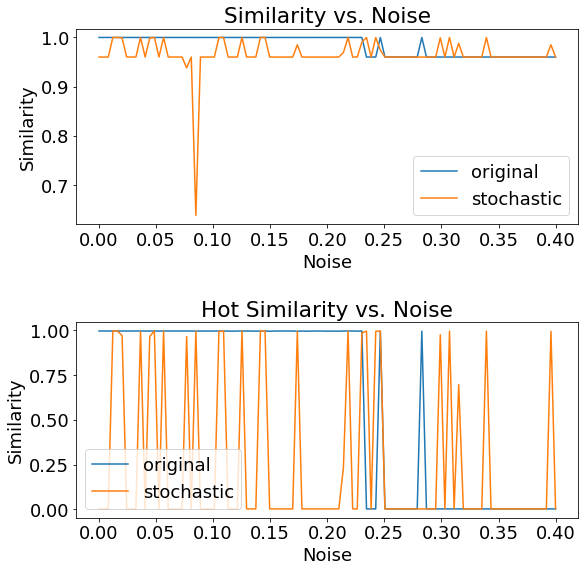

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(9,9))
plt.subplots_adjust(hspace = 0.5)

ax0.plot(x, np.array(o_set), label='original')
ax0.plot(x, np.array(s_set), label='stochastic')
ax0.set_xlabel("Noise")
ax0.set_ylabel("Similarity")
ax0.set_title("Similarity vs. Noise")
ax0.legend()

ax1.plot(x, np.array(o_h_set), label='original')
ax1.plot(x, np.array(s_h_set), label='stochastic')
ax1.set_xlabel("Noise")
ax1.set_ylabel("Similarity")
ax1.set_title("Hot Similarity vs. Noise")
ax1.legend();

# Spiking TPAM #

## Resonate-and-fire TPAM ##

In [ ]:
N_vec = 500
N_inh_ff = 5
N_out = 60

pvecs = crvec(N_vec, N_out).T
Ks = int(0.05 * N_vec)

for d in range(N_out):
    ip = np.random.choice(N_vec, size=(N_vec-Ks), replace=False)
    pvecs[ip, d] = 0
    
pmat = np.dot(pvecs, np.conj(pvecs.T)) / Ks

np.fill_diagonal(pmat, 0)

In [ ]:
# Neuron parameters
C_Sh = 4 * nF # Capacitance
L_Sh = 10e-3/1e-9  * henry # Inductance

g_l = 30.0 * nS # leak conductance
E_l = -60.0 * mV # Resting potential

V_t = -58.0 * mV # Threshold


eqs_2_h = Equations('''
    dVs/dt = (g_l * (E_l - Vs) - 2*pi*Us + I_ext) / C_Sh : volt
    dUs/dt = -2*pi*(E_l - Vs) / L_Sh : amp
    I_ext : amp
    ''')

s_h = '''
mag_v : 1
mag_u : 1
'''
s_h_on_pre = '''
Vs_post += mag_v * mV
Us_post += mag_u * nA
'''

In [ ]:
cycle_freq = 1/(np.sqrt(L_Sh * C_Sh))
VU_factor = sqrt(C_Sh/L_Sh) * mV/nA

print(cycle_freq)

In [ ]:
nreps = 1

target_idx = 22

init_vector = pvecs[:, target_idx].copy()

init_vector[200:] = 0
keep_idx = np.abs(init_vector) > 0.5

stt = phase2spikes(init_vector)*second  +0.11*second
#spike_indices = np.zeros_like(stt)
spike_indices = np.arange(stt.shape[0])

#keep_idx = np.random.rand(stt.shape[0]) < 1
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

spike_times = np.tile(stt, (nreps))
spike_indices = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times[(i*N_vec):((i+1)*N_vec)] = spike_times[:N_vec] + i * 200*ms

In [ ]:
G_pre = SpikeGeneratorGroup(N_vec, spike_indices, spike_times)
G_post = NeuronGroup(N_vec, model=eqs_2_h, threshold='Vs>V_t and Us>0*nA',  
                     refractory=120*ms, method='euler')

G_post.Vs = (E_l + 0.0*mV) * ones(N_vec)
G_post.Us = 0.0 * VU_factor * nA * ones(N_vec)
G_post.I_ext = 0

S_pre_post = Synapses(G_pre, G_post, s_h, on_pre=s_h_on_pre, method='euler')
S_recurrent = Synapses(G_post, G_post, s_h, on_pre=s_h_on_pre, method='euler')

# Input connections
S_pre_post.connect(j='i')
S_pre_post.mag_u = -0.1 * VU_factor
S_pre_post.mag_v = 3

# Recurrent connections
syn_thresh = 0.1 / (2*N_vec) ** 0.5
synidxs = np.where(np.abs(pmat.T) > syn_thresh)
S_recurrent.connect(i=synidxs[0], j=synidxs[1])

syn_idxs_f = np.where(np.abs(pmat.T).flatten() > syn_thresh)[0]
syn_abs = np.abs(pmat.T).flatten()
syn_phase = -1*np.angle(pmat.T).flatten()

syn_g = 5.0
S_recurrent.mag_v = syn_g * syn_abs[syn_idxs_f] * np.cos(syn_phase[syn_idxs_f])
S_recurrent.mag_u = syn_g * syn_abs[syn_idxs_f] * VU_factor * np.sin(syn_phase[syn_idxs_f])

# Monitors
SpM_post = SpikeMonitor(G_post)
StM_post = StateMonitor(G_post, True, record=True)

In [ ]:
complex_net = Network()
complex_net.add(G_pre)
complex_net.add(G_post)

complex_net.add(S_pre_post)
complex_net.add(S_recurrent)

complex_net.add(SpM_post)
complex_net.add(StM_post)

complex_net.store('init')

In [ ]:
run_time = 5.0 * second
#complex_net.restore('init')
tst = time.time()
complex_net.run(run_time)
print("elapsed", time.time() - tst, "seconds")

In [ ]:
figure(figsize=(3.5,3))

spike_trains_post = SpM_post.spike_trains()

for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)

ylim([0, N_vec])
xlim([0, 1])

xlabel('Time (s)')

plt.tight_layout()

In [ ]:
figure(figsize=(8,3.5))

subplot(121)
c=0
for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)
    if len(spike_trains_post[i])>2:
        c+=1
        
print(c, '==', Ks)

xlim([4,5])
ylim([0, N_vec])

xlabel('Time (s)')
title('Network')


target_vector = pvecs[:, target_idx].copy()

stt = phase2spikes(target_vector)*second  +0.11*second
spike_indices = np.arange(stt.shape[0])

keep_idx = np.abs(target_vector) > 0.5
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

nreps = 10
spike_times_target = np.tile(stt, (nreps))
spike_indices_target = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times_target[(np.arange(len(stt)) + i * len(stt))] = spike_times_target[:len(stt)] + i * 200*ms

    
subplot(122)
for i in range(N_vec):
    sp_times = spike_times_target[spike_indices_target==i]
    plot(sp_times, i*np.ones(sp_times.shape) , '|', mew=2)

xlabel('Time (s)')
xlim([0, 1])
ylim([0, N_vec])
title('Target')

plt.tight_layout()

In [ ]:
figure(figsize=(3.5,3))

N_ex = spike_indices[0]
ex=2

plot(StM_post.Vs[N_ex]/mV, StM_post.Us[N_ex]/nA, c='cyan', lw=2)
plot(StM_post.Vs[ex]/mV, StM_post.Us[ex]/nA, c=[0.3, 0.3, 0.3], lw=2)

xl_V = 8*mV
xlim([E_l/mV - xl_V/mV, E_l/mV + xl_V/mV])
ylim([- xl_V * VU_factor /mV, xl_V * VU_factor/mV])

xticks([])
yticks([])
xlabel('$V$ (mV)')
ylabel('$U$ (nA)')

plt.tight_layout()

## Stochastic Resonate-and-Fire Neurons ##

In [ ]:
N_vec = 500
N_inh_ff = 5
N_out = 60

pvecs = crvec(N_vec, N_out).T
Ks = int(0.05 * N_vec)

for d in range(N_out):
    ip = np.random.choice(N_vec, size=(N_vec-Ks), replace=False)
    pvecs[ip, d] = 0
    
pmat = np.dot(pvecs, np.conj(pvecs.T)) / Ks

np.fill_diagonal(pmat, 0)

In [ ]:
# Neuron parameters
C_Sh = 4 * nF # Capacitance
L_Sh = 10e-3/1e-9  * henry # Inductance

g_l = 30.0 * nS # leak conductance
E_l = -60.0 * mV # Resting potential

V_t = -58.0 * mV # Threshold


eqs_2_h = Equations('''
    dVs/dt = (g_l * (E_l - Vs) - 2*pi*Us + I_ext) / C_Sh : volt
    dUs/dt = -2*pi*(E_l - Vs) / L_Sh : amp
    I_ext : amp
    ''')

s_h = '''
mag_v : 1
mag_u : 1
'''
s_h_on_pre = '''
Vs_post += mag_v * mV
Us_post += mag_u * nA
'''

In [ ]:
cycle_freq = 1/(np.sqrt(L_Sh * C_Sh))
VU_factor = sqrt(C_Sh/L_Sh) * mV/nA

print(cycle_freq)

In [ ]:
nreps = 1

target_idx = 22

init_vector = pvecs[:, target_idx].copy()

init_vector[200:] = 0
keep_idx = np.abs(init_vector) > 0.5

stt = phase2spikes(init_vector)*second  +0.11*second
#spike_indices = np.zeros_like(stt)
spike_indices = np.arange(stt.shape[0])

#keep_idx = np.random.rand(stt.shape[0]) < 1
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

spike_times = np.tile(stt, (nreps))
spike_indices = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times[(i*N_vec):((i+1)*N_vec)] = spike_times[:N_vec] + i * 200*ms

In [ ]:
G_pre = SpikeGeneratorGroup(N_vec, spike_indices, spike_times)
G_post = NeuronGroup(N_vec, model=eqs_2_h, threshold='Vs>V_t and Us>0*nA',  
                     refractory=120*ms, method='euler')

G_post.Vs = (E_l + 0.0*mV) * ones(N_vec)
G_post.Us = 0.0 * VU_factor * nA * ones(N_vec)
G_post.I_ext = 0

S_pre_post = Synapses(G_pre, G_post, s_h, on_pre=s_h_on_pre, method='euler')
S_recurrent = Synapses(G_post, G_post, s_h, on_pre=s_h_on_pre, method='euler')

# Input connections
S_pre_post.connect(j='i')
S_pre_post.mag_u = -0.1 * VU_factor
S_pre_post.mag_v = 3

# Recurrent connections
syn_thresh = 0.1 / (2*N_vec) ** 0.5
synidxs = np.where(np.abs(pmat.T) > syn_thresh)
S_recurrent.connect(i=synidxs[0], j=synidxs[1])

syn_idxs_f = np.where(np.abs(pmat.T).flatten() > syn_thresh)[0]
syn_abs = np.abs(pmat.T).flatten()
syn_phase = -1*np.angle(pmat.T).flatten()

syn_g = 5.0
S_recurrent.mag_v = syn_g * syn_abs[syn_idxs_f] * np.cos(syn_phase[syn_idxs_f])
S_recurrent.mag_u = syn_g * syn_abs[syn_idxs_f] * VU_factor * np.sin(syn_phase[syn_idxs_f])

# Monitors
SpM_post = SpikeMonitor(G_post)
StM_post = StateMonitor(G_post, True, record=True)

In [ ]:
complex_net = Network()
complex_net.add(G_pre)
complex_net.add(G_post)

complex_net.add(S_pre_post)
complex_net.add(S_recurrent)

complex_net.add(SpM_post)
complex_net.add(StM_post)

complex_net.store('init')

In [ ]:
run_time = 5.0 * second
#complex_net.restore('init')
tst = time.time()
complex_net.run(run_time)
print("elapsed", time.time() - tst, "seconds")

In [ ]:
figure(figsize=(3.5,3))

spike_trains_post = SpM_post.spike_trains()

for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)

ylim([0, N_vec])
xlim([0, 1])

xlabel('Time (s)')

plt.tight_layout()

In [ ]:
figure(figsize=(8,3.5))

subplot(121)
c=0
for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)
    if len(spike_trains_post[i])>2:
        c+=1
        
print(c, '==', Ks)

xlim([4,5])
ylim([0, N_vec])

xlabel('Time (s)')
title('Network')


target_vector = pvecs[:, target_idx].copy()

stt = phase2spikes(target_vector)*second  +0.11*second
spike_indices = np.arange(stt.shape[0])

keep_idx = np.abs(target_vector) > 0.5
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

nreps = 10
spike_times_target = np.tile(stt, (nreps))
spike_indices_target = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times_target[(np.arange(len(stt)) + i * len(stt))] = spike_times_target[:len(stt)] + i * 200*ms

    
subplot(122)
for i in range(N_vec):
    sp_times = spike_times_target[spike_indices_target==i]
    plot(sp_times, i*np.ones(sp_times.shape) , '|', mew=2)

xlabel('Time (s)')
xlim([0, 1])
ylim([0, N_vec])
title('Target')

plt.tight_layout()

In [ ]:
figure(figsize=(3.5,3))

N_ex = spike_indices[0]
ex=2

plot(StM_post.Vs[N_ex]/mV, StM_post.Us[N_ex]/nA, c='cyan', lw=2)
plot(StM_post.Vs[ex]/mV, StM_post.Us[ex]/nA, c=[0.3, 0.3, 0.3], lw=2)

xl_V = 8*mV
xlim([E_l/mV - xl_V/mV, E_l/mV + xl_V/mV])
ylim([- xl_V * VU_factor /mV, xl_V * VU_factor/mV])

xticks([])
yticks([])
xlabel('$V$ (mV)')
ylabel('$U$ (nA)')

plt.tight_layout()